In [ ]:
#Implementation for Task 1
#using sirs broilerplate code as a template

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import tensorflow as tf  
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
import os

# Load and preprocess the data
data = []  # List to store image data
labels = []  # List to store labels

# Define a function to extract the person label from the file name
def extract_person_label(file_name):
    return int(file_name.split('.')[0].replace('subject', '')) - 1  # Subtract 1 to make labels start from 0

# Load data and labels
# Assuming the dataset files are in the 'dataset' directory
dataset_dir = 'D:/FAST_NUCES/7thSemester/DLP/Assignment/Assignment1/Dataset/yale'

for file_name in os.listdir(dataset_dir):
    img = plt.imread(os.path.join(dataset_dir, file_name))
    # print(img.shape)
    data.append(img.flatten())  # Flatten image into a 1D array
    labels.append(extract_person_label(file_name))

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


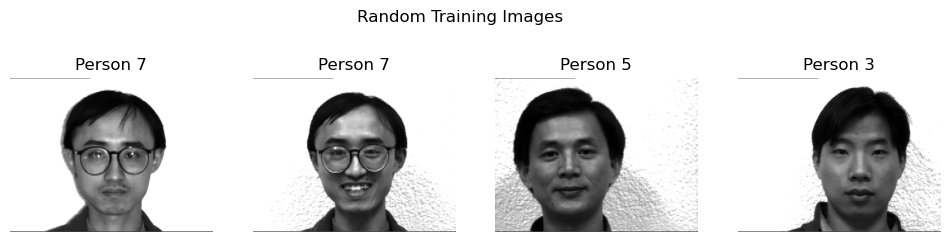

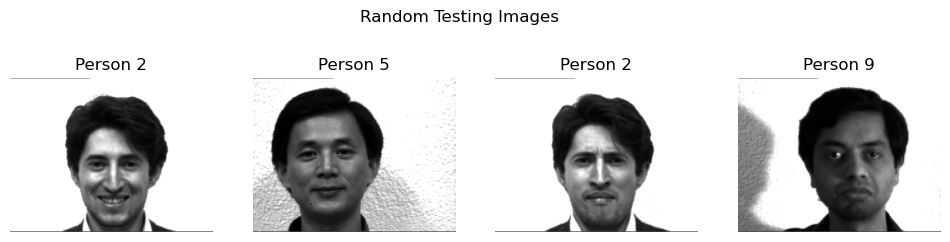

In [3]:
import random

# Randomly select four indices from the training dataset
train_indices = random.sample(range(len(X_train)), 4)

# Randomly select four indices from the testing dataset
test_indices = random.sample(range(len(X_test)), 4)

# Function to display images
def display_images(images, labels, title):
    plt.figure(figsize=(12, 3))
    plt.suptitle(title)
    for i, (image, label) in enumerate(zip(images, labels), 1):
        plt.subplot(1, 4, i)
        plt.imshow(image.reshape((243, 320)), cmap='gray')
        plt.title(f"Person {label}")
        plt.axis('off')
    plt.show()

# Display four random training images
train_images_to_display = X_train[train_indices]
train_labels_to_display = y_train[train_indices]
display_images(train_images_to_display, train_labels_to_display, "Random Training Images")

# Display four random testing images
test_images_to_display = X_test[test_indices]
test_labels_to_display = y_test[test_indices]
display_images(test_images_to_display, test_labels_to_display, "Random Testing Images")

In [4]:
# Define a function to create the MLP model
def create_mlp_model(hidden_layers, neurons_per_layer, activation_function):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    for _ in range(hidden_layers): #reminder to self _ means we dont expect the variable itself to be used in the loop.
        model.add(tf.keras.layers.Dense(neurons_per_layer, activation=activation_function))

    model.add(tf.keras.layers.Dense(15, activation='softmax'))  # 15 output classes for 15 subjects
    return model

In [5]:
# Function to train and evaluate the MLP model
def train_evaluate_mlp(hidden_layers, neurons_per_layer, activation_function, epochs=20, batch_size=32):
    model = create_mlp_model(hidden_layers, neurons_per_layer, activation_function)
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # Test the model and calculate evaluation metrics
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')

    return accuracy, precision, recall, f1, history


In [6]:
# Experiment 2: With hyperparameter tuning (GridSearchCV)
param_grid = {
    'hidden_layers': [1, 2, 3],
    'neurons_per_layer': [32, 64, 128],
    'activation_function': ['relu', 'sigmoid']
}

# Create an instance of your MLP model
#mlp_model = create_mlp_model(hidden_layers=2, neurons_per_layer=64, activation_function='relu')
#Note to future self- making this instance does not force GridSearchCV to use these settings. It is just a template for the architecture you're using.
#instead it will use the param_grid to find the best settings.
#That didn't work but the logic behind my statements remains the same.

mlp_classifier = KerasClassifier(build_fn=create_mlp_model, epochs=20, batch_size=32) 


# Initialize GridSearchCV with the MLP model as the estimator
grid_search = GridSearchCV(estimator=mlp_classifier,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=3)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

accuracy2, precision2, recall2, f1_2, history2 = train_evaluate_mlp(**best_params, epochs=20, batch_size=32)


C:\Users\rahei\AppData\Local\Temp\ipykernel_18616\2438970920.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  mlp_classifier = KerasClassifier(build_fn=create_mlp_model, epochs=20, batch_size=32)
d:\Anaconda\ActualInstallation\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
54 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Anaconda\ActualInstallation\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score

AttributeError: 'Sequential' object has no attribute 'loss'

In [ ]:
#Experiment Tracking
experiments = []

# Experiment 1: Without hyperparameter tuning
accuracy1, precision1, recall1, f1_1, history1 = train_evaluate_mlp(hidden_layers=2, neurons_per_layer=64, activation_function='relu', epochs=20, batch_size=32)

# Experiment 2: With hyperparameter tuning (GridSearchCV)
# ...

experiments.append(("Without Tuning", accuracy1, precision1, recall1, f1_1, history1))
experiments.append(("With Tuning", accuracy2, precision2, recall2, f1_2, history2))


In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()